In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import cv2
import time
from google.colab.patches import cv2_imshow

# VGG Block

In [ ]:
class VGGBlock(tf.keras.layers.Layer):
    def __init__(self, num_convs, num_filters):
        '''
        num_convs(int): number of convolution layers in block
        num_filters(int): number of filters in each convolution layers in block
        '''
        super(VGGBlock, self).__init__()

        self.block = tf.keras.models.Sequential()

        for _ in range(num_convs):
            self.block.add(tf.keras.layers.Conv2D(filters=num_filters, kernel_size=3,
                                                  padding='same', activation='relu'))
        
        self.block.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=2))
    
    def call(self, X):
        return self.block(X)
    



In [ ]:
X = tf.random.uniform((1, 224, 224, 1))
block = VGGBlock(num_convs=1, num_filters=64)
block(X).shape

TensorShape([1, 112, 112, 64])

# VGG16 Model

In [ ]:
class VGG16(tf.keras.Model):
    def __init__(self, num_class):
        '''
        num_class(int): number of classes in dataset.
        '''
        super(VGG16, self).__init__()

        #block 1
        self.block1 = VGGBlock(num_convs=2, num_filters=64)
        #block 2
        self.block2 = VGGBlock(num_convs=2, num_filters=128)
        #block 3
        self.block3 = VGGBlock(num_convs=3, num_filters=256)
        #block 4
        self.block4 = VGGBlock(num_convs=3, num_filters=512)
        #block 5
        self.block5 = VGGBlock(num_convs=3, num_filters=512)
        #Flatten layer
        self.flatten = tf.keras.layers.Flatten()
        #fully connected block
        self.fc1 = tf.keras.layers.Dense(4096, activation='relu')
        
        self.fc2 = tf.keras.layers.Dense(4096, activation='relu')
        self.fc3 = tf.keras.layers.Dense(num_class, activation='softmax')

    def call(self, X):
        X = self.block1(X)
        X = self.block2(X)
        X = self.block3(X)
        X = self.block4(X)
        X = self.block5(X)
        X = self.flatten(X)
        X = self.fc1(X)
        X = self.fc2(X)
        return self.fc3(X)
    
    def summary_model(self, input_shape):
        x = tf.keras.layers.Input(shape=input_shape)
        return tf.keras.models.Model(inputs=[x], outputs=self.call(x)).summary()
    
    def plot_model(self, input_shape, save_path):
        x = tf.keras.layers.Input(shape=input_shape)
        model = tf.keras.models.Model(inputs=[x], outputs=self.call(x))
        return tf.keras.utils.plot_model(model, to_file=save_path, show_shapes=True)


In [ ]:
model_test = VGG16(num_class=10)
model_test.summary_model(input_shape=(224, 224, 3))

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vgg_block_1 (VGGBlock)      (None, 112, 112, 64)      38720     
                                                                 
 vgg_block_2 (VGGBlock)      (None, 56, 56, 128)       221440    
                                                                 
 vgg_block_3 (VGGBlock)      (None, 28, 28, 256)       1475328   
                                                                 
 vgg_block_4 (VGGBlock)      (None, 14, 14, 512)       5899776   
                                                                 
 vgg_block_5 (VGGBlock)      (None, 7, 7, 512)         7079424   
                                                                 
 flatten (Flatten)           (None, 25088)             0     

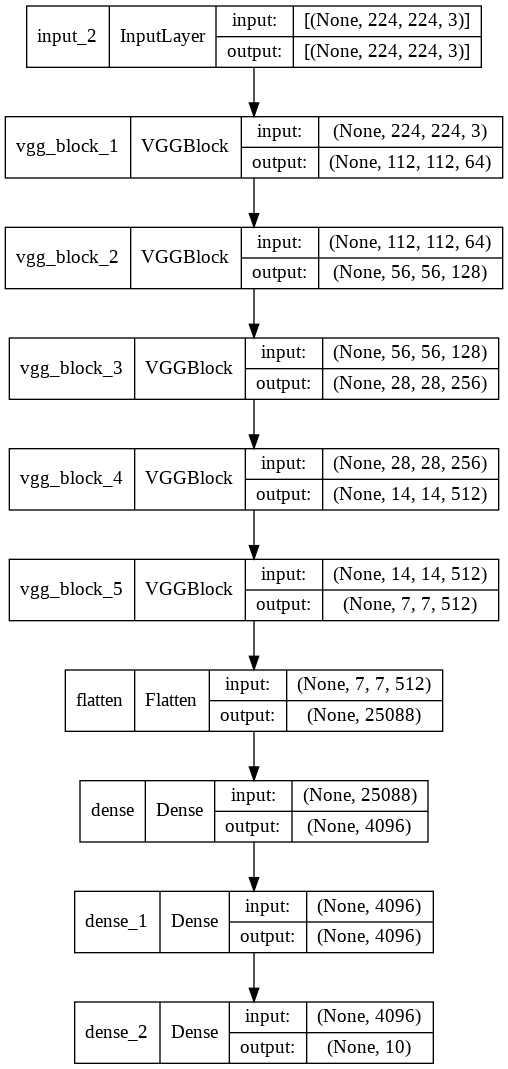

In [ ]:
model_test.plot_model(input_shape=(224, 224, 3), save_path='model.png')

# Preprocessing the dataset

In [ ]:
!gdown --id 1RL0T7Rg4XqQNRCkjfnLo4goOJQ7XZro9
!unzip cats_and_dogs_filtered.zip

Downloading...
From: https://drive.google.com/uc?id=1RL0T7Rg4XqQNRCkjfnLo4goOJQ7XZro9
To: /content/cats_and_dogs_filtered.zip
100% 68.6M/68.6M [00:00<00:00, 173MB/s]
Archive:  cats_and_dogs_filtered.zip
   creating: cats_and_dogs_filtered/
  inflating: cats_and_dogs_filtered/vectorize.py  
   creating: cats_and_dogs_filtered/validation/
   creating: cats_and_dogs_filtered/train/
   creating: cats_and_dogs_filtered/validation/dogs/
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2127.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2126.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2125.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2124.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2123.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2122.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2121.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2120.jpg  
  inflating: cats_and_dogs_fi

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, 
                                   width_shift_range=0.2, height_shift_range=0.2,
                                   shear_range=0.2, zoom_range=0.2, 
                                   horizontal_flip=True, vertical_flip=True, 
                                   fill_mode='nearest')

train_dataset = train_datagen.flow_from_directory(directory='/content/cats_and_dogs_filtered/train', batch_size=20,
                                                  class_mode='categorical', target_size=(224, 224))

val_datagen = ImageDataGenerator(rescale=1./255)
val_dataset = val_datagen.flow_from_directory(directory='/content/cats_and_dogs_filtered/validation', batch_size=20,
                                              class_mode='categorical', target_size=(224, 224))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
train_dataset.class_indices

{'cats': 0, 'dogs': 1}

# Train model

## define number of epoch, optimizer, loss function, evaluate metric and model

In [ ]:
EPOCH = 20
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_function = tf.keras.losses.CategoricalCrossentropy()
train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
val_acc_metric = tf.keras.metrics.CategoricalAccuracy()
batch_size = 20

model = VGG16(num_class=2)

## Custom training loop

In [ ]:
# custom training step
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_function(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    train_acc_metric.update_state(y, logits)
    return loss_value

# custom test step
@tf.function
def test_step(x, y):
    val_logits = model(x, training=False)
    val_acc_metric.update_state(y, val_logits)

# Custom traning loop
for epoch in range(EPOCH):

    print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()

    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):

        loss_value = train_step(x_batch_train, y_batch_train)

        if step % 100 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %s samples" % ((step + 1) * batch_size))
    train_acc = train_acc_metric.result()
    print("Training acc at step: %.4f" % (float(train_acc),))
    train_acc_metric.reset_states()

    for x_batch_val, y_batch_val in val_dataset:
        test_step(x_batch_val, y_batch_val)

    val_acc = val_acc_metric.result()
    val_acc_metric.reset_states()
    print("Validation acc: %.4f" % (float(val_acc),))
    print("Time taken: %.2fs" % (time.time() - start_time))


Start of epoch 0
Training loss (for one batch) at step 0: 0.6932
Seen so far: 20 samples
Training loss (for one batch) at step 100: 0.6922
Seen so far: 2020 samples
Training loss (for one batch) at step 200: 0.6908
Seen so far: 4020 samples
Training loss (for one batch) at step 300: 0.6932
Seen so far: 6020 samples
Training loss (for one batch) at step 400: 0.6940
Seen so far: 8020 samples
Training loss (for one batch) at step 500: 0.6948
Seen so far: 10020 samples
Training loss (for one batch) at step 600: 0.6932
Seen so far: 12020 samples
Training loss (for one batch) at step 700: 0.6946
Seen so far: 14020 samples
Training loss (for one batch) at step 800: 0.6937
Seen so far: 16020 samples
Training loss (for one batch) at step 900: 0.6932
Seen so far: 18020 samples
Training loss (for one batch) at step 1000: 0.6925
Seen so far: 20020 samples
Training loss (for one batch) at step 1100: 0.6941
Seen so far: 22020 samples
Training loss (for one batch) at step 1200: 0.6937
Seen so far: 2